Video işleniyor...
İşlenen kare: 10/322
İşlenen kare: 20/322
İşlenen kare: 30/322
İşlenen kare: 40/322
İşlenen kare: 50/322
İşlenen kare: 60/322
İşlenen kare: 70/322
İşlenen kare: 80/322
İşlenen kare: 90/322
İşlenen kare: 100/322
İşlenen kare: 110/322
İşlenen kare: 120/322
İşlenen kare: 130/322
İşlenen kare: 140/322
İşlenen kare: 150/322
İşlenen kare: 160/322
İşlenen kare: 170/322
İşlenen kare: 180/322
İşlenen kare: 190/322
İşlenen kare: 200/322
İşlenen kare: 210/322
İşlenen kare: 220/322
İşlenen kare: 230/322
İşlenen kare: 240/322
İşlenen kare: 250/322
İşlenen kare: 260/322
İşlenen kare: 270/322
İşlenen kare: 280/322
İşlenen kare: 290/322
İşlenen kare: 300/322
İşlenen kare: 310/322
İşlenen kare: 320/322
Video sonuna gelindi.
Video kaydedildi: output_analiz.mp4

Operatör 1 Bölgesi İş Adımları:
  Adım 1: 0.72s - 0.92s (Süre: 0.20s)
  Adım 2: 1.24s - 2.44s (Süre: 1.20s)
  Adım 3: 2.88s - 3.40s (Süre: 0.52s)
  Adım 4: 4.80s - 5.08s (Süre: 0.28s)
  Adım 5: 8.12s - 8.24s (Süre: 0.12s)
  Adı

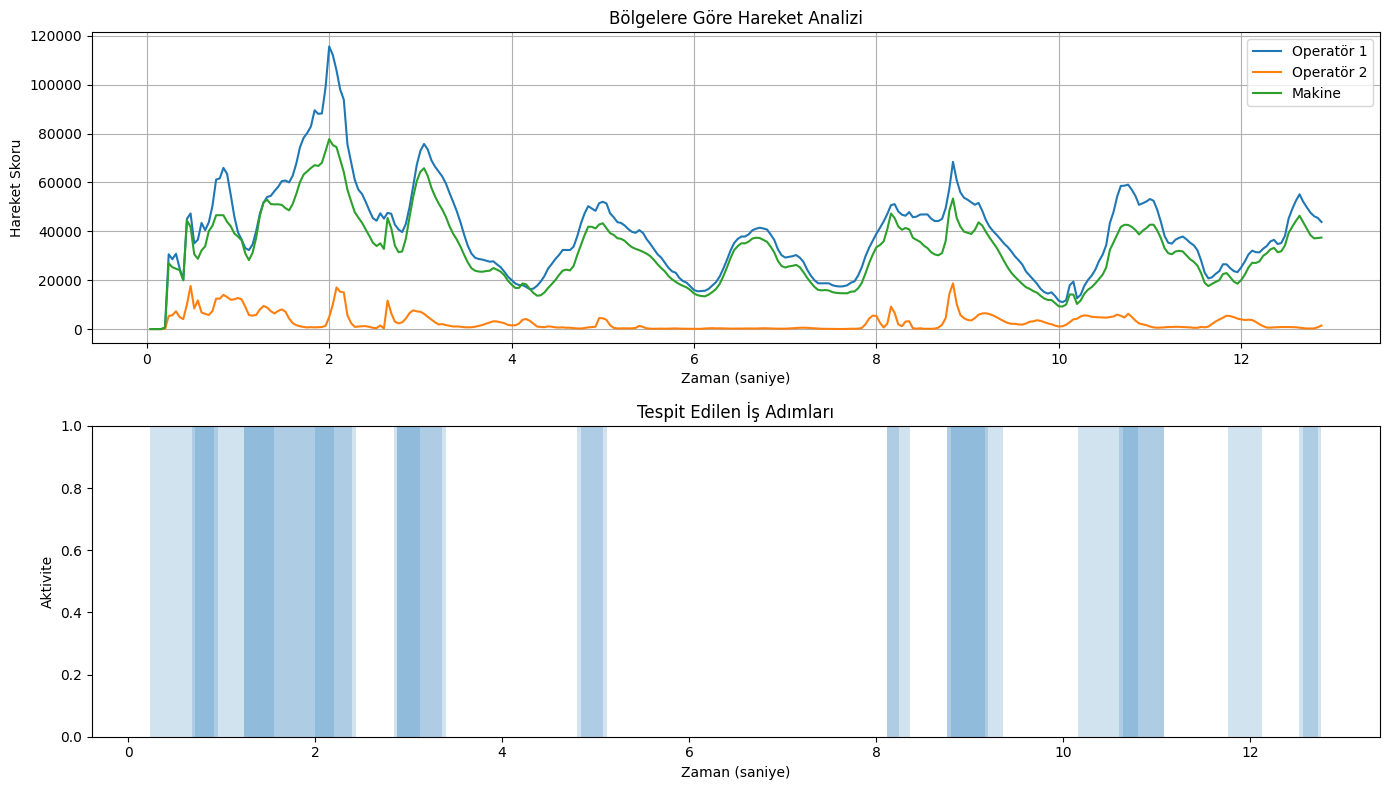

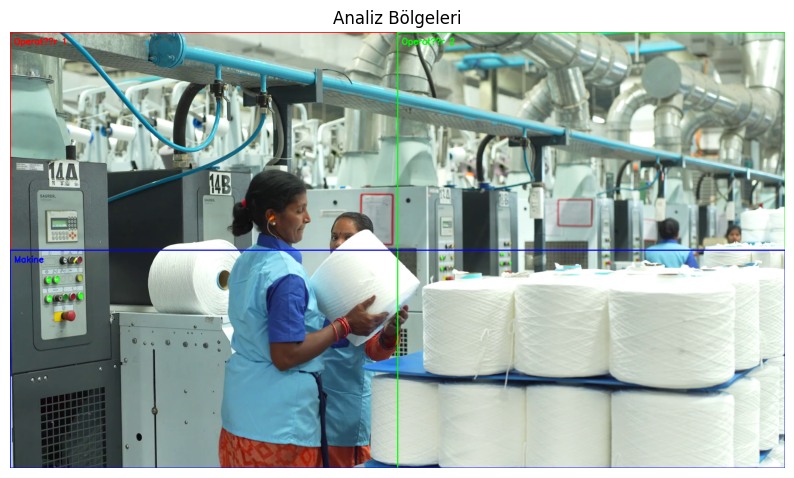

In [ ]:
import cv2
import numpy as np
import time

# ───────────────────────────────
# Ayarlar
# ───────────────────────────────
INPUT_VIDEO  = "factory_video.mp4"
OUTPUT_VIDEO = "output_analiz.mp4"

# Hareket eşiği ayarları
HISTORY       = 50
VAR_THRESHOLD = 25

# ROI tanımlayıcı
def define_regions(frame_shape):
    h, w = frame_shape[:2]
    # (x, y, genişlik, yükseklik, renk, isim)
    return [
        (0,       0, w//2, h,         (255, 0,   0), "Operatör 1"),
        (w//2,    0, w//2, h,         (0,   255, 0), "Operatör 2"),
        (0,   h//2,   w,  h//2,       (0,   0, 255), "Makine")
    ]

# ───────────────────────────────
# Başlat
# ───────────────────────────────
cap = cv2.VideoCapture(INPUT_VIDEO)
if not cap.isOpened():
    raise IOError("Video açılamadı!")

fps          = cap.get(cv2.CAP_PROP_FPS) or 25
width        = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height       = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc       = cv2.VideoWriter_fourcc(*"mp4v")
writer       = cv2.VideoWriter(OUTPUT_VIDEO, fourcc, fps, (width, height))

# Arka plan çıkarıcı
fgbg = cv2.createBackgroundSubtractorMOG2(
            history=HISTORY,
            varThreshold=VAR_THRESHOLD,
            detectShadows=True)

# ROI listesi
ret, first = cap.read()
if not ret:
    print("İlk kare okuma hatası!")
    exit()
regions = define_regions(first.shape)
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)     # Başa dön

# FPS ölçümü
prev_time = time.time()
frame_count = 0

# Analiz sonuçlarını saklamak için
region_motion = {region[5]: [] for region in regions}
frame_times = []

print("Video işleniyor...")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Video sonuna gelindi.")
        break

    frame_count += 1
    current_time = frame_count / fps
    frame_times.append(current_time)

    fgmask = fgbg.apply(frame)
    fgmask_bin = (fgmask == 255).astype(np.uint8)

    # ROI'lerde işlem
    for (x, y, w, h, color, name) in regions:
        roi_mask = fgmask_bin[y:y+h, x:x+w]
        motion_val = int(roi_mask.sum())  # Beyaz piksel sayısı
        region_motion[name].append(motion_val)

        # Görüntü üzerine bilgileri çiz
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        cv2.putText(frame, f"{name}: {motion_val}",
                    (x+10, y+30), cv2.FONT_HERSHEY_SIMPLEX,
                    0.7, color, 2)

    # Anlık FPS
    curr_time = time.time()
    fps_inst = 1.0/(curr_time - prev_time)
    prev_time = curr_time
    cv2.putText(frame, f"FPS: {fps_inst:.1f}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,255), 2)

    # Zaman bilgisi
    cv2.putText(frame, f"Zaman: {current_time:.2f}s", (10, 70),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,255), 2)

    # Sadece kaydet, gösterme
    writer.write(frame)

    # İlerleme göster
    if frame_count % 10 == 0:
        print(f"İşlenen kare: {frame_count}/{int(cap.get(cv2.CAP_PROP_FRAME_COUNT))}")

# Temizlik
cap.release()
writer.release()
print(f"Video kaydedildi: {OUTPUT_VIDEO}")

# Analiz sonuçlarını göster
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
for name, values in region_motion.items():
    plt.plot(frame_times, values, label=name)
plt.title('Bölgelere Göre Hareket Analizi')
plt.xlabel('Zaman (saniye)')
plt.ylabel('Hareket Skoru')
plt.legend()
plt.grid(True)

# İş adımlarını tespit et
plt.subplot(2, 1, 2)
for name, values in region_motion.items():
    threshold = np.mean(values) * 1.2
    high_motion_periods = []
    current_period = None

    for i, score in enumerate(values):
        if score > threshold and current_period is None:
            current_period = {'start': frame_times[i], 'end': frame_times[i]}
        elif score > threshold and current_period is not None:
            current_period['end'] = frame_times[i]
        elif score <= threshold and current_period is not None:
            if current_period['end'] - current_period['start'] >= 0.1:
                high_motion_periods.append(current_period)
            current_period = None

    # Son periyodu ekle
    if current_period is not None and current_period['end'] - current_period['start'] >= 0.1:
        high_motion_periods.append(current_period)

    # Grafik üzerinde yüksek hareket dönemlerini göster
    for period in high_motion_periods:
        plt.axvspan(period['start'], period['end'], alpha=0.2, label=f"{name} Aktivite")

    print(f"\n{name} Bölgesi İş Adımları:")
    total_active_time = 0
    for i, period in enumerate(high_motion_periods):
        duration_step = period['end'] - period['start']
        total_active_time += duration_step
        print(f"  Adım {i+1}: {period['start']:.2f}s - {period['end']:.2f}s (Süre: {duration_step:.2f}s)")

    if high_motion_periods:
        total_video_duration = frame_times[-1]
        print(f"  Toplam aktif süre: {total_active_time:.2f}s")
        print(f"  Verimlilik oranı: {(total_active_time/total_video_duration)*100:.2f}%")
    else:
        print("  Belirgin hareket tespit edilemedi.")

plt.title('Tespit Edilen İş Adımları')
plt.xlabel('Zaman (saniye)')
plt.ylabel('Aktivite')
plt.tight_layout()
plt.show()

# Örnek kare göster
cap = cv2.VideoCapture(INPUT_VIDEO)
ret, sample_frame = cap.read()
if ret:
    plt.figure(figsize=(10, 6))
    img = cv2.cvtColor(sample_frame, cv2.COLOR_BGR2RGB)

    # Bölgeleri çiz
    for (x, y, w, h, color, name) in regions:
        cv2.rectangle(img, (x, y), (x+w, y+h), color, 2)
        cv2.putText(img, name, (x+10, y+30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    plt.imshow(img)
    plt.title('Analiz Bölgeleri')
    plt.axis('off')
    plt.show()
cap.release()

Video boyutu: 1920x1080, FPS: 25.0, Toplam kare: 322
Video işleniyor...
İşlenen kare: 20/322
İşlenen kare: 40/322
İşlenen kare: 60/322
İşlenen kare: 80/322
İşlenen kare: 100/322
İşlenen kare: 120/322
İşlenen kare: 140/322
İşlenen kare: 160/322
İşlenen kare: 180/322
İşlenen kare: 200/322
İşlenen kare: 220/322
İşlenen kare: 240/322
İşlenen kare: 260/322
İşlenen kare: 280/322
İşlenen kare: 300/322
İşlenen kare: 320/322
Video işleme tamamlandı.
Spagetti diyagramı oluşturuluyor...
Spagetti diyagramı kaydedildi: spaghetti_diagram.png


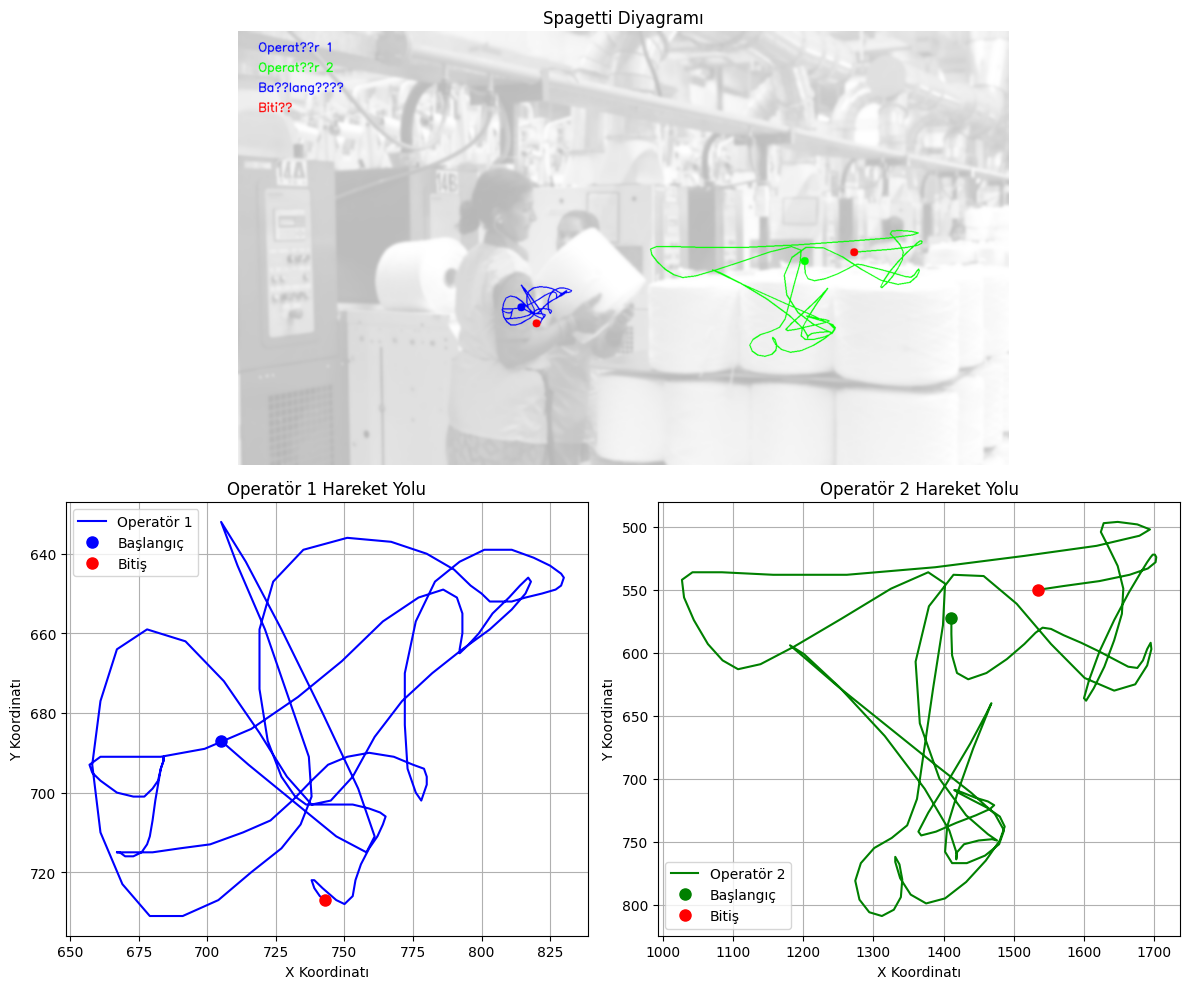


Hareket Analizi:
Operatör 1 toplam hareket mesafesi: 1326.13 piksel
Operatör 2 toplam hareket mesafesi: 4553.20 piksel
Operatör 1/Operatör 2 hareket oranı: 0.29

Hareket animasyonu oluşturuluyor...
Hareket animasyonu kaydedildi: spaghetti_animation.mp4

Isı haritası oluşturuluyor...
Isı haritası kaydedildi: heatmap.png


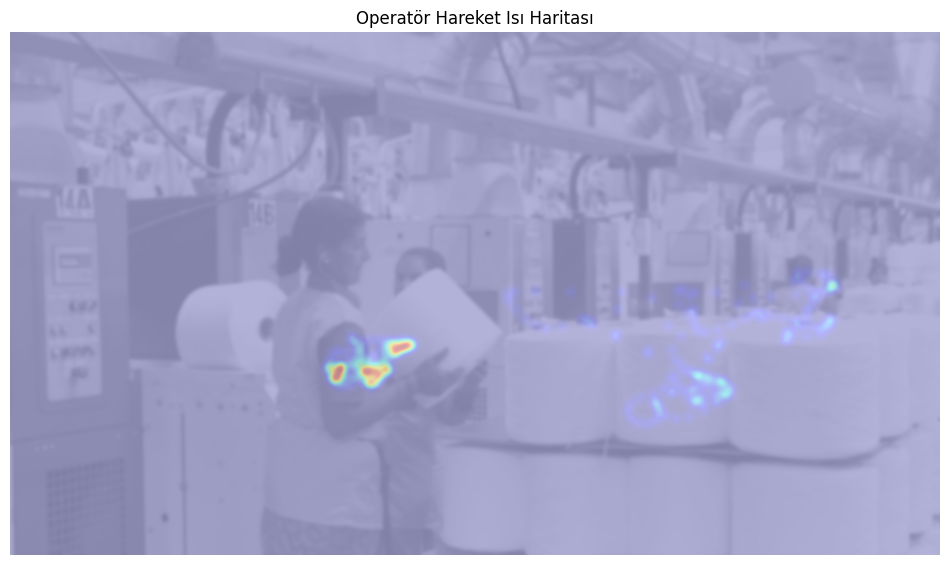


Tüm analizler tamamlandı.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Video dosyasını aç
cap = cv2.VideoCapture('factory_video.mp4')
if not cap.isOpened():
    raise IOError("Video açılamadı!")

# Video özellikleri
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"Video boyutu: {width}x{height}, FPS: {fps}, Toplam kare: {frame_count}")

# İlk kareyi al ve arka plan olarak kullan
ret, first_frame = cap.read()
if not ret:
    raise IOError("İlk kare okunamadı!")

# Arka plan görüntüsü oluştur (ilk kareyi gri tonlama ve hafif bulanıklaştır)
background = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
background = cv2.GaussianBlur(background, (21, 21), 0)
background = cv2.cvtColor(background, cv2.COLOR_GRAY2BGR)
background = cv2.addWeighted(background, 0.3, np.ones_like(background)*255, 0.7, 0)

# Spagetti diyagramı için boş görüntü
spaghetti_diagram = background.copy()

# Operatör bölgeleri (sol ve sağ yarı)
op1_roi = (0, 0, width//2, height)  # x, y, w, h
op2_roi = (width//2, 0, width//2, height)  # x, y, w, h

# Operatör izleme için değişkenler
op1_positions = []
op2_positions = []
frame_indices = []

# Hareket tespiti için arka plan çıkarıcı
fgbg = cv2.createBackgroundSubtractorMOG2(history=50, varThreshold=25, detectShadows=True)

# Renk filtreleme için HSV aralıkları (açık mavi ve turuncu)
# Açık mavi (gömlek)
lower_blue = np.array([90, 50, 50])
upper_blue = np.array([130, 255, 255])

# Turuncu (pantolon)
lower_orange = np.array([10, 100, 100])
upper_orange = np.array([25, 255, 255])

# Video başına dön
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Her kareyi işle
frame_idx = 0
sample_interval = 2  # Her 2 karede bir örnek al

print("Video işleniyor...")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    if frame_idx % sample_interval == 0:
        # Ön plan maskesi
        fgmask = fgbg.apply(frame)

        # HSV'ye dönüştür
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Mavi ve turuncu maskeleri
        mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)
        mask_orange = cv2.inRange(hsv, lower_orange, upper_orange)

        # Renk ve hareket maskelerini birleştir
        combined_mask = cv2.bitwise_or(mask_blue, mask_orange)
        combined_mask = cv2.bitwise_and(combined_mask, fgmask)

        # Operatör 1 bölgesi için maske
        x1, y1, w1, h1 = op1_roi
        op1_mask = combined_mask[y1:y1+h1, x1:x1+w1]

        # Operatör 2 bölgesi için maske
        x2, y2, w2, h2 = op2_roi
        op2_mask = combined_mask[y2:y2+h2, x2:x2+w2]

        # Operatör 1 için merkez nokta bul
        if np.sum(op1_mask) > 100:  # Eşik değeri
            M = cv2.moments(op1_mask)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"]) + x1
                cy = int(M["m01"] / M["m00"]) + y1
                op1_positions.append((cx, cy))
            else:
                # Eğer moment hesaplanamazsa, bölgenin ortasını al
                op1_positions.append((x1 + w1//2, y1 + h1//2))
        else:
            # Hareket yoksa son pozisyonu koru
            if op1_positions:
                op1_positions.append(op1_positions[-1])
            else:
                op1_positions.append((x1 + w1//2, y1 + h1//2))

        # Operatör 2 için merkez nokta bul
        if np.sum(op2_mask) > 100:  # Eşik değeri
            M = cv2.moments(op2_mask)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"]) + x2
                cy = int(M["m01"] / M["m00"]) + y2
                op2_positions.append((cx, cy))
            else:
                # Eğer moment hesaplanamazsa, bölgenin ortasını al
                op2_positions.append((x2 + w2//2, y2 + h2//2))
        else:
            # Hareket yoksa son pozisyonu koru
            if op2_positions:
                op2_positions.append(op2_positions[-1])
            else:
                op2_positions.append((x2 + w2//2, y2 + h2//2))

        frame_indices.append(frame_idx)

    frame_idx += 1
    if frame_idx % 20 == 0:
        print(f"İşlenen kare: {frame_idx}/{frame_count}")

cap.release()
print("Video işleme tamamlandı.")

# Pozisyonları düzgünleştir (gürültüyü azalt)
op1_positions_array = np.array(op1_positions)
op2_positions_array = np.array(op2_positions)

# Gaussian smoothing
op1_x_smooth = gaussian_filter1d(op1_positions_array[:, 0], sigma=2)
op1_y_smooth = gaussian_filter1d(op1_positions_array[:, 1], sigma=2)
op2_x_smooth = gaussian_filter1d(op2_positions_array[:, 0], sigma=2)
op2_y_smooth = gaussian_filter1d(op2_positions_array[:, 1], sigma=2)

op1_positions_smooth = list(zip(op1_x_smooth, op1_y_smooth))
op2_positions_smooth = list(zip(op2_x_smooth, op2_y_smooth))

# Spagetti diyagramı çiz
print("Spagetti diyagramı oluşturuluyor...")

# Operatör 1 için yolu çiz (mavi)
for i in range(1, len(op1_positions_smooth)):
    start_point = (int(op1_positions_smooth[i-1][0]), int(op1_positions_smooth[i-1][1]))
    end_point = (int(op1_positions_smooth[i][0]), int(op1_positions_smooth[i][1]))
    cv2.line(spaghetti_diagram, start_point, end_point, (255, 0, 0), 2)

# Operatör 2 için yolu çiz (yeşil)
for i in range(1, len(op2_positions_smooth)):
    start_point = (int(op2_positions_smooth[i-1][0]), int(op2_positions_smooth[i-1][1]))
    end_point = (int(op2_positions_smooth[i][0]), int(op2_positions_smooth[i][1]))
    cv2.line(spaghetti_diagram, start_point, end_point, (0, 255, 0), 2)

# Başlangıç ve bitiş noktalarını işaretle
cv2.circle(spaghetti_diagram, (int(op1_positions_smooth[0][0]), int(op1_positions_smooth[0][1])), 10, (255, 0, 0), -1)
cv2.circle(spaghetti_diagram, (int(op1_positions_smooth[-1][0]), int(op1_positions_smooth[-1][1])), 10, (0, 0, 255), -1)
cv2.circle(spaghetti_diagram, (int(op2_positions_smooth[0][0]), int(op2_positions_smooth[0][1])), 10, (0, 255, 0), -1)
cv2.circle(spaghetti_diagram, (int(op2_positions_smooth[-1][0]), int(op2_positions_smooth[-1][1])), 10, (0, 0, 255), -1)

# Lejant ekle
cv2.putText(spaghetti_diagram, "Operatör 1", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
cv2.putText(spaghetti_diagram, "Operatör 2", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
cv2.putText(spaghetti_diagram, "Başlangıç", (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
cv2.putText(spaghetti_diagram, "Bitiş", (50, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

# Spagetti diyagramını kaydet
cv2.imwrite("spaghetti_diagram.png", spaghetti_diagram)
print("Spagetti diyagramı kaydedildi: spaghetti_diagram.png")

# Matplotlib ile göster
plt.figure(figsize=(12, 10))

# Spagetti diyagramı
plt.subplot(2, 1, 1)
plt.imshow(cv2.cvtColor(spaghetti_diagram, cv2.COLOR_BGR2RGB))
plt.title('Spagetti Diyagramı')
plt.axis('off')

# Hareket yolları grafiği
plt.subplot(2, 2, 3)
plt.plot(op1_x_smooth, op1_y_smooth, 'b-', label='Operatör 1')
plt.plot(op1_x_smooth[0], op1_y_smooth[0], 'bo', markersize=8, label='Başlangıç')
plt.plot(op1_x_smooth[-1], op1_y_smooth[-1], 'ro', markersize=8, label='Bitiş')
plt.gca().invert_yaxis()  # Y ekseni yukarıdan aşağıya
plt.title('Operatör 1 Hareket Yolu')
plt.xlabel('X Koordinatı')
plt.ylabel('Y Koordinatı')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(op2_x_smooth, op2_y_smooth, 'g-', label='Operatör 2')
plt.plot(op2_x_smooth[0], op2_y_smooth[0], 'go', markersize=8, label='Başlangıç')
plt.plot(op2_x_smooth[-1], op2_y_smooth[-1], 'ro', markersize=8, label='Bitiş')
plt.gca().invert_yaxis()  # Y ekseni yukarıdan aşağıya
plt.title('Operatör 2 Hareket Yolu')
plt.xlabel('X Koordinatı')
plt.ylabel('Y Koordinatı')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("spaghetti_analysis.png", dpi=300)
plt.show()

# Hareket analizi istatistikleri
op1_distance = 0
op2_distance = 0

for i in range(1, len(op1_positions_smooth)):
    op1_distance += np.sqrt((op1_positions_smooth[i][0] - op1_positions_smooth[i-1][0])**2 +
                           (op1_positions_smooth[i][1] - op1_positions_smooth[i-1][1])**2)

for i in range(1, len(op2_positions_smooth)):
    op2_distance += np.sqrt((op2_positions_smooth[i][0] - op2_positions_smooth[i-1][0])**2 +
                           (op2_positions_smooth[i][1] - op2_positions_smooth[i-1][1])**2)

print("\nHareket Analizi:")
print(f"Operatör 1 toplam hareket mesafesi: {op1_distance:.2f} piksel")
print(f"Operatör 2 toplam hareket mesafesi: {op2_distance:.2f} piksel")
print(f"Operatör 1/Operatör 2 hareket oranı: {op1_distance/op2_distance:.2f}")

# Animasyon oluştur (hareket yollarının zaman içinde gelişimi)
print("\nHareket animasyonu oluşturuluyor...")

# Animasyon için boş görüntü
animation_frames = []
animation_img = background.copy()

# Her 5 noktada bir kare oluştur
step = 5
for i in range(0, len(op1_positions_smooth), step):
    frame = animation_img.copy()

    # Operatör 1 için o ana kadar olan yolu çiz
    for j in range(1, i+1):
        start_point = (int(op1_positions_smooth[j-1][0]), int(op1_positions_smooth[j-1][1]))
        end_point = (int(op1_positions_smooth[j][0]), int(op1_positions_smooth[j][1]))
        cv2.line(frame, start_point, end_point, (255, 0, 0), 2)

    # Operatör 2 için o ana kadar olan yolu çiz
    for j in range(1, min(i+1, len(op2_positions_smooth))):
        start_point = (int(op2_positions_smooth[j-1][0]), int(op2_positions_smooth[j-1][1]))
        end_point = (int(op2_positions_smooth[j][0]), int(op2_positions_smooth[j][1]))
        cv2.line(frame, start_point, end_point, (0, 255, 0), 2)

    # Operatörlerin mevcut konumlarını işaretle
    if i < len(op1_positions_smooth):
        cv2.circle(frame, (int(op1_positions_smooth[i][0]), int(op1_positions_smooth[i][1])), 5, (255, 0, 0), -1)

    if i < len(op2_positions_smooth):
        cv2.circle(frame, (int(op2_positions_smooth[i][0]), int(op2_positions_smooth[i][1])), 5, (0, 255, 0), -1)

    # Zaman bilgisini ekle
    time_sec = i * sample_interval / fps
    cv2.putText(frame, f"Zaman: {time_sec:.2f}s", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    animation_frames.append(frame)

# Animasyonu kaydet
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('spaghetti_animation.mp4', fourcc, 5, (width, height))

for frame in animation_frames:
    out.write(frame)

out.release()
print("Hareket animasyonu kaydedildi: spaghetti_animation.mp4")

# Isı haritası (heatmap) oluştur
print("\nIsı haritası oluşturuluyor...")

heatmap = np.zeros((height, width), dtype=np.float32)

# Operatör 1 için ısı haritası
for pos in op1_positions_smooth:
    x, y = int(pos[0]), int(pos[1])
    if 0 <= x < width and 0 <= y < height:
        heatmap[y, x] += 1

# Operatör 2 için ısı haritası
for pos in op2_positions_smooth:
    x, y = int(pos[0]), int(pos[1])
    if 0 <= x < width and 0 <= y < height:
        heatmap[y, x] += 1

# Isı haritasını bulanıklaştır
heatmap = cv2.GaussianBlur(heatmap, (51, 51), 0)

# Normalize et
heatmap = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX)
heatmap = np.uint8(heatmap)

# Renkli ısı haritası oluştur
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Arka plan ile birleştir
heatmap_overlay = cv2.addWeighted(background, 0.7, heatmap_color, 0.3, 0)

# Isı haritasını kaydet
cv2.imwrite("heatmap.png", heatmap_overlay)
print("Isı haritası kaydedildi: heatmap.png")

# Isı haritasını göster
plt.figure(figsize=(12, 10))
plt.imshow(cv2.cvtColor(heatmap_overlay, cv2.COLOR_BGR2RGB))
plt.title('Operatör Hareket Isı Haritası')
plt.axis('off')
plt.savefig("heatmap_analysis.png", dpi=300)
plt.show()

print("\nTüm analizler tamamlandı.")